本版模型主要内容：
- 实现多个模型：lr, dt, rf, gbt, nb 共五个模型，将五个模型的ROC曲线画到一张图里。  
- 选取其中最好的模型计算最佳分割阈值，并画混淆矩阵和模型重要性   
- 其他功能：交叉验证作调参、处理onehot变量

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jdk/jdk1.8.0_191'
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from pyspark import SparkContext
from pyspark import SparkConf
import pyspark.ml.tuning as tune
from pyspark.ml import Pipeline
import pyspark.sql.types as T
from pyspark.sql import SparkSession
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
import pyspark.ml.evaluation as ev
from pyspark.ml.classification import LogisticRegression, \
DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.mllib.classification import SVMWithSGD
import pyspark.sql.functions as F

from scipy.spatial import distance
from pyspark.ml.clustering import PowerIterationClustering, BisectingKMeans, GaussianMixture
from pyspark.ml.fpm import FPGrowth


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

%matplotlib inline


# pyspark初始化

In [2]:
spark = SparkSession.builder.getOrCreate()
labels = [
    ('INFANT_ALIVE_AT_REPORT', T.IntegerType()),   #Y
    ('BIRTH_PLACE', T.StringType()),              # onehot变量
    ('MOTHER_AGE_YEARS', T.IntegerType()),
    ('FATHER_COMBINED_AGE', T.IntegerType()),
    ('CIG_BEFORE', T.IntegerType()),
    ('CIG_1_TRI', T.IntegerType()),
    ('CIG_2_TRI', T.IntegerType()),
    ('CIG_3_TRI', T.IntegerType()),
    ('MOTHER_HEIGHT_IN', T.IntegerType()),
    ('MOTHER_PRE_WEIGHT', T.IntegerType()),
    ('MOTHER_DELIVERY_WEIGHT', T.IntegerType()),
    ('MOTHER_WEIGHT_GAIN', T.IntegerType()),
    ('DIABETypeS_PRE', T.IntegerType()),
    ('DIABETypeS_GEST', T.IntegerType()),
    ('HYP_TypeNS_PRE', T.IntegerType()),
    ('HYP_TypeNS_GEST', T.IntegerType()),
    ('PREV_BIRTH_PRETypeRM', T.IntegerType())
]

# 读取时指定每一列的数据类型
schema = T.StructType([
    T.StructField(e[0], e[1], False) for e in labels
])

df = spark.read.csv('births_transformed.csv.gz', 
                        header=True, 
                        schema=schema).sample(False, 0.1, 42)
print(df.count())

4687


In [3]:
print(df.columns)

['INFANT_ALIVE_AT_REPORT', 'BIRTH_PLACE', 'MOTHER_AGE_YEARS', 'FATHER_COMBINED_AGE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'DIABETypeS_PRE', 'DIABETypeS_GEST', 'HYP_TypeNS_PRE', 'HYP_TypeNS_GEST', 'PREV_BIRTH_PRETypeRM']


改名：指定目标变量的名字为label，所有机器学习模型的默认目标名称都是label

In [4]:
df = df.withColumnRenamed('INFANT_ALIVE_AT_REPORT', 'label')

# one-hot特征处理
BIRTH_PLACE是one-hot变量:
BIRTH_PLACE->BIRTH_PLACE_INT->BIRTH_PLACE_VEC

In [5]:
df = df.withColumn('BIRTH_PLACE_INT', df['BIRTH_PLACE'].cast(T.IntegerType()))

df.select('BIRTH_PLACE', 'BIRTH_PLACE_INT').show(4)

+-----------+---------------+
|BIRTH_PLACE|BIRTH_PLACE_INT|
+-----------+---------------+
|          1|              1|
|          1|              1|
|          1|              1|
|          1|              1|
+-----------+---------------+
only showing top 4 rows



类似dataframe中的value_counts()功能

In [6]:
df.groupBy('BIRTH_PLACE_INT').count().orderBy('count').show()

+---------------+-----+
|BIRTH_PLACE_INT|count|
+---------------+-----+
|              6|    1|
|              9|    1|
|              5|    5|
|              7|   13|
|              2|   16|
|              3|   27|
|              4|   31|
|              1| 4593|
+---------------+-----+



再增加一个onehot变量模拟多onehot变量的真实数据场景

In [7]:
df = df.withColumn('new_cat', (F.col('BIRTH_PLACE_INT') / 3).cast('int'))
df.groupBy('new_cat').count().orderBy('count').show()

+-------+-----+
|new_cat|count|
+-------+-----+
|      3|    1|
|      2|   14|
|      1|   63|
|      0| 4609|
+-------+-----+



In [8]:
# 对BIRTH_PLACE_INT构建onehot
str_cols = ['BIRTH_PLACE_INT', 'new_cat']
encoder = [ft.OneHotEncoder(
    inputCol=c, 
    outputCol='%s_vec' % c) for c in str_cols]

# 将所有的特征整和到一起

In [9]:
#labels中第一行是Y，第二行是onehot变量，从第三行开始是X变量，labels[2:]代表了所有的X
featuresCreator = ft.VectorAssembler(
    inputCols=[col[0] for col in labels[2:]] + [ec.getOutputCol() for ec in encoder], 
    outputCol='features'
)

# 数据处理pipeline

In [10]:
# 创建转换通道
pipeline = Pipeline(stages=encoder + [featuresCreator])

# train & test split

In [11]:
df_train, df_test = df \
    .randomSplit([0.7, 0.3], seed=666)

data_transformer = pipeline.fit(df_train)

# 查看train中样本分布比例作为weight

In [12]:
y_dist = df_train.groupBy('label').count().orderBy('label')
y_dist.show()

# 计算权重
y_dist = y_dist.collect()
w = y_dist[1][1] / y_dist[0][1]
print('weight : %4.6f' % (w))

+-----+-----+
|label|count|
+-----+-----+
|    0| 1594|
|    1| 1649|
+-----+-----+

weight : 1.034504


对少数样本加权

In [13]:
df_train = df_train.withColumn('weight', F.udf(lambda dt: 1 if dt == 0 else w)(F.col('label')).cast('float'))
df_train.select('label', 'weight').show(5)#

+-----+------+
|label|weight|
+-----+------+
|    0|   1.0|
|    0|   1.0|
|    0|   1.0|
|    0|   1.0|
|    0|   1.0|
+-----+------+
only showing top 5 rows



In [14]:
df_train.groupBy('weight').count().orderBy('count').show()

+---------+-----+
|   weight|count|
+---------+-----+
|      1.0| 1594|
|1.0345044| 1649|
+---------+-----+



In [15]:
df_train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- BIRTH_PLACE: string (nullable = true)
 |-- MOTHER_AGE_YEARS: integer (nullable = true)
 |-- FATHER_COMBINED_AGE: integer (nullable = true)
 |-- CIG_BEFORE: integer (nullable = true)
 |-- CIG_1_TRI: integer (nullable = true)
 |-- CIG_2_TRI: integer (nullable = true)
 |-- CIG_3_TRI: integer (nullable = true)
 |-- MOTHER_HEIGHT_IN: integer (nullable = true)
 |-- MOTHER_PRE_WEIGHT: integer (nullable = true)
 |-- MOTHER_DELIVERY_WEIGHT: integer (nullable = true)
 |-- MOTHER_WEIGHT_GAIN: integer (nullable = true)
 |-- DIABETypeS_PRE: integer (nullable = true)
 |-- DIABETypeS_GEST: integer (nullable = true)
 |-- HYP_TypeNS_PRE: integer (nullable = true)
 |-- HYP_TypeNS_GEST: integer (nullable = true)
 |-- PREV_BIRTH_PRETypeRM: integer (nullable = true)
 |-- BIRTH_PLACE_INT: integer (nullable = true)
 |-- new_cat: integer (nullable = true)
 |-- weight: float (nullable = true)



# 创建模型
创建6个模型

In [16]:
# naive bayes
nb = NaiveBayes(weightCol="weight")

# gbt
gbt = GBTClassifier()

# svm
svm = SVMWithSGD()

# logistic regression
lr = LogisticRegression(
    maxIter=10, 
    regParam=0.01,     
    weightCol="weight")    #指定weight

# DecisionTree model.
dt = DecisionTreeClassifier()

# random forest
rf = RandomForestClassifier()



In [17]:
?NaiveBayes

# 使用交叉验证进行网格搜索超参调优


In [18]:
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='label')

grid_lr = tune.ParamGridBuilder() \
    .addGrid(lr.maxIter,  
             [2, 10, 50]) \
    .addGrid(lr.regParam, 
             [0.01, 0.05, 0.3]) \
    .build()
    
grid_nb = tune.ParamGridBuilder() \
    .addGrid(nb.smoothing,  
             [0.7, 1.0]) \
    .build()    
    
grid_dt = tune.ParamGridBuilder() \
    .addGrid(dt.maxDepth,  
             [2, 4, 6, 8]) \
    .addGrid(dt.maxBins, 
             [16, 32, 64]) \
    .build()
    
grid_rf = tune.ParamGridBuilder() \
    .addGrid(rf.maxDepth,  
             [2, 4, 8]) \
    .addGrid(rf.maxBins, 
             [16, 32, 16]) \
    .addGrid(rf.numTrees, 
            [16,20,24]) \
    .build()
    
grid_gbt = tune.ParamGridBuilder() \
    .addGrid(gbt.maxDepth,  
             [2, 4, 8]) \
    .addGrid(gbt.maxBins, 
             [16, 32, 64]) \
    .build()

cv_lr = tune.CrossValidator(
    estimator=lr, 
    estimatorParamMaps=grid_lr,
    evaluator=evaluator,
    numFolds=5
)

cv_nb = tune.CrossValidator(
    estimator=nb,    
    estimatorParamMaps=grid_nb,
    evaluator=evaluator,
    numFolds=5
)
cv_gbt = tune.CrossValidator(
    estimator=gbt,
    estimatorParamMaps=grid_gbt, 
    evaluator=evaluator,
    numFolds=5
)

cv_rf = tune.CrossValidator(
    estimator=rf,
    estimatorParamMaps=grid_rf, 
    evaluator=evaluator,
    numFolds=5
)

cv_dt = tune.CrossValidator(
    estimator=dt,
    estimatorParamMaps=grid_dt, 
    evaluator=evaluator,
    numFolds=5
)

model_dict = {'lr':cv_lr, 'nb':cv_nb, 'dt':cv_dt, 'rf':cv_rf, 'gbt':cv_gbt}

# fit & predict

In [19]:
model_dict = {'rf':cv_rf}

In [20]:
# data transform
train_data = data_transformer.transform(df_train)
test_data = data_transformer.transform(df_test)

# fit & predict
model_results = {}
for k, cv in model_dict.items():
    print(k, cv)
    # fit
    cvModel = cv.fit(train_data)

    # predict
    test_model = cvModel.transform(test_data)
    
    model_results.update({k: (cvModel, test_model)})

rf CrossValidator_f98b3b4408aa


# 评估模型性能

## 模型准确率

In [21]:
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='label')

for k, m in model_results.items():
    auroc = evaluator.evaluate(m[1], {evaluator.metricName: 'areaUnderROC'})
    aupr = evaluator.evaluate(m[1], {evaluator.metricName: 'areaUnderPR'})
    print('model: {}'.format(k))
    print('测试集AUROC: %4.3f' % (auroc))
    print('测试集AUPR: %4.3f\n' % (aupr))


model: rf
测试集AUROC: 0.759
测试集AUPR: 0.719



从预测结果中提取出阳性的预测概率

In [719]:
test_all = pd.DataFrame()
for k, m in model_results.items():
    print(k)
    test_model = m[1]
    test_result = test_model.select('probability', 'label')
    to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
    test_result = test_result.withColumn('proba', to_array('probability'))
    test_result = test_result.withColumn('pos_proba', F.udf(lambda t: round(t[1],2))(F.col('proba')))
    test_result = test_result.toPandas()
    if len(test_all) == 0:
        test_all = test_result[['label', 'pos_proba']].rename(columns={'pos_proba':'%s_proba' % k})
    else:
        test_all['%s_proba' % k] = test_result['pos_proba']

test_all.head()

rf


,label,rf_proba
0,0,0.16
1,0,0.14
2,0,0.15
3,0,0.14
4,0,0.57


转成pandas画ROC曲线

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


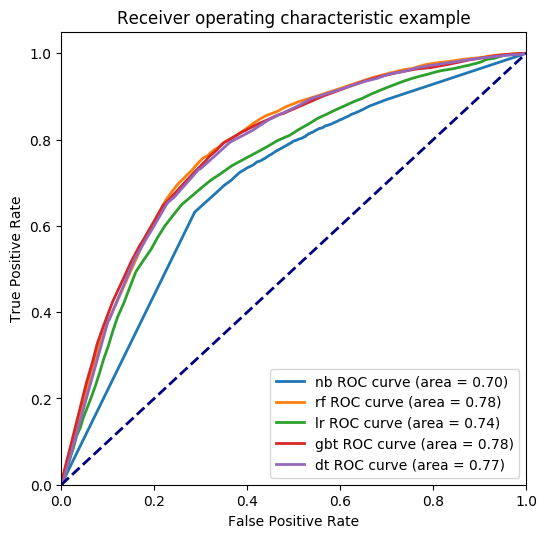

In [257]:
test_all = test_all.astype('float')

y_test = test_all['label']

plt.figure(figsize=(6, 6),dpi=100)
lw = 2
# model_name_dict = {'nb':'NaiveBayes', 'rf':'RandomForest', 'lr':'LogisticRegression', 
#                   'gbt':'G'}
for f in ['nb', 'rf', 'lr', 'gbt', 'dt']:
    y_pred = test_all['%s_proba' % f]

    roc_auc = roc_auc_score(y_test, y_pred)
    fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真正率和假正率
    plt.plot(fpr, tpr, 
             lw=lw, label='%s ROC curve (area = %0.2f)' % (f, roc_auc)) ###假正率为横坐标，真正率为纵坐标做曲线

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# 对最佳模型计算F1和分割阈值、特征重要性、混淆矩阵

In [258]:
y_pred = test_all['rf_proba']
print('最佳模型：RF')
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

max_f1_score = 0
best_thresh = 0

for p, r, \
    t in zip(precision, recall, thresholds):

    f1_score = 2 * (p * r) / (p + r)
    if f1_score > max_f1_score:
        best_thresh = t
        max_f1_score = f1_score

print('best_thresh:', best_thresh)
print('max_f1_score:', max_f1_score)

最佳模型：RF
best_thresh: 0.37
max_f1_score: 0.7534118526827444


## 可视化混淆矩阵

预测混淆矩阵：
[[3812 2848]
 [1073 5988]]


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


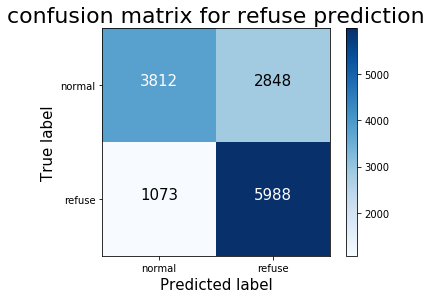

In [260]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)



    
cm = confusion_matrix(y_test, y_pred>best_thresh)
print('预测混淆矩阵：\n{}'.format(cm))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plot_confusion_matrix(cm, ['normal', 'refuse'], 'confusion matrix for refuse prediction')

## 选取其中一个模型计算特征重要性
为了方便计算， 对于onehot变量的特征重要性，取最大值，合并成一个变量

In [720]:
# 计算onehot变量的数量，例如第一个变量有8个不同取值， 第二个变量有4个不同取值，则列表为【0， 8， 4】，添加一个0在最前边方便后面的运算

count_vec = [df_train.groupby(str_cols[i]).count().distinct().count() for i in range(len(str_cols))]
count_vec = [0] + count_vec
count_vec

[0, 8, 4]

Text(0.5,1,'feature importance')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


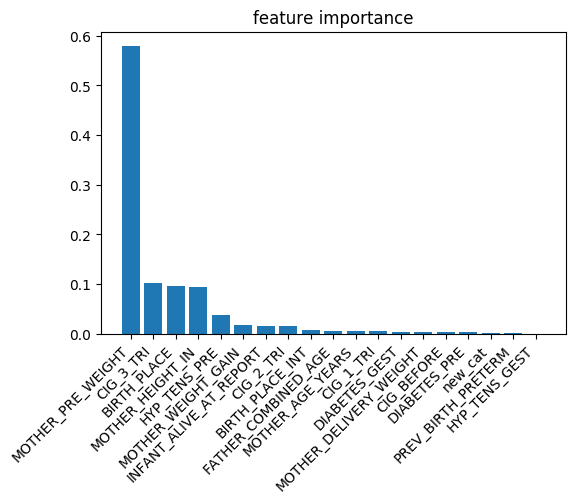

In [738]:
cvModel = model_results['rf'][0]
fea_imp = cvModel.bestModel.featureImportances.toArray().tolist()  #所有变量的重要性，包括了普通的变量和非onehot变量
fea_non_onehot = [c for c in df.columns if c not in str_cols]     #普通的变量的名称
fea_imp_non_onehot = fea_imp[:len(fea_non_onehot)]  #普通的变量的特重要性


fea_imp_onehot = [np.max(fea_imp[len(fea_non_onehot) + int(np.sum(count_vec[0:i])):
                                 len(fea_non_onehot) + int(np.sum(count_vec[0:i+1]))]) 
                  for i in range(1, len(count_vec))]  #onehot变量取最大的特征重要性

fea_name = fea_non_onehot + str_cols  #指定onehot变量的名称
fea_imp = fea_imp_non_onehot + fea_imp_onehot


fea_name_imp = dict(zip(fea_name, fea_imp))
fea_name_imp = sorted(fea_name_imp.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)

plt.figure(dpi=100)
plt.bar([f[0] for f in fea_name_imp], [f[1] for f in fea_name_imp])
plt.xticks(rotation=45,ha='right')
plt.title('feature importance')

# 保存数据转换管道和模型

In [1]:
pipelinePath = './RF_Pipeline'
modelPath = './RF_Model'

In [ ]:
# 保存模型
pipeline.write().overwrite().save(pipelinePath)
cvModel.write().overwrite().save(modelPath)


In [3]:
%ls RF_Pipeline
%ls RF_Model

ls: cannot access 'pipelinePath': No such file or directory
ls: cannot access 'modelPath': No such file or directory


# load saved model

In [ ]:
loadedPipeline = Pipeline.load(pipelinePath)
loadedPipelineModel = PipelineModel.load(modelPath)

# shap  
对pyspark的模型使用shap，不能有onehot特征，否则会报"NotImplementedError: CategoricalSplit are not yet implemented"的error  
Ref:   
https://github.com/slundberg/shap/issues/38:   
shap doesn't support categorical split so you can't have categorical features in your mode

In [22]:
import shap
# load JS visualization code to notebook
shap.initjs()

# data preprocess, give up the onehot feature
feas = [col[0] for col in labels[2:]]
featuresCreator = ft.VectorAssembler(
    inputCols=feas, 
    outputCol='features'
)
data_transformer = featuresCreator.transform(df_train)
train_data = featuresCreator.transform(df_train)
test_data = featuresCreator.transform(df_test)

# model
classifiers = [GBTClassifier(labelCol="label", featuresCol="features"),
                   RandomForestClassifier(labelCol="label", featuresCol="features"),
                   DecisionTreeClassifier(labelCol="label", featuresCol="features")]

classifier = classifiers[0]
model = classifier.fit(train_data)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning
shap.force_plot is slow for many thousands of rows, try subsampling your data.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans


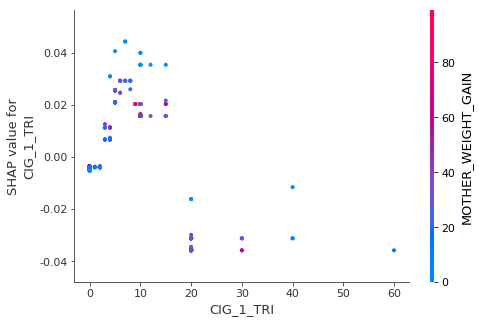

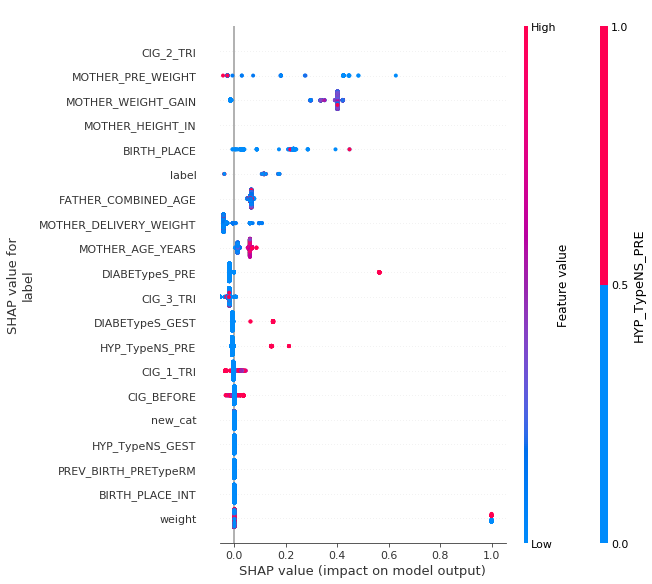

In [26]:
explainer = shap.TreeExplainer(model)
X =df_train.toPandas()
shap_values = explainer.shap_values(X)
expected_values = explainer.expected_value

#predictions = model.transform(test_data).select("rawPrediction")\
#        .rdd.map(lambda x:[float(y) for y in x['rawPrediction']]).toDF(['class0','class1']).toPandas()
    
# visualize the first prediction's explaination
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(5, shap_values, X, show=False)
shap.dependence_plot("label", shap_values, X, show=False)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, show=False)

# decision boundary
- PCA降维到2D空间  
- 不同模型建模  
- 对预测结果可视化

In [225]:
pcaCreator = ft.PCA(k=2, inputCol='features', outputCol='pca_features')

df = data_transformer.transform(df)
pca_model = pcaCreator.fit(df)

df_2d = pca_model.transform(df).select('pca_features', 'label')
df_2d.show(4)

+--------------------+-----+
|        pca_features|label|
+--------------------+-----+
|[-1404.7923333120...|    0|
|[-264.73359702385...|    0|
|[-225.93591237257...|    0|
|[-196.34777330846...|    0|
+--------------------+-----+
only showing top 4 rows



In [230]:
ds = df_2d.toPandas()

ds['f1'] = ds.apply(lambda x: x['pca_features'][0], axis=1)
ds['f2'] = ds.apply(lambda x: x['pca_features'][1], axis=1)
ds = ds.drop('pca_features', axis=1)
ds.head()

,label,f1,f2
0,0,-1404.792333,-198.763606
1,0,-264.733597,-50.355893
2,0,-225.935912,-40.516908
3,0,-196.347773,-44.806058
4,0,-169.369534,-37.826619


In [248]:
def simple_over_sample(ds):
    print('采样前：')
    print(ds['label'].value_counts())
    ds_0 = ds.query('label==0')
    ds_1 = ds.query('label==1')

    ds_1_more=ds_1.sample(100000, replace=True, random_state=1)
    ds_sampled = pd.concat([ds_0, ds_1_more], axis=0)
    print('采样后：')
    print(ds_sampled['label'].value_counts())
simple_over_sample(ds)

1    23349
0    22080
Name: label, dtype: int64
1    100000
0     22080
Name: label, dtype: int64


<Figure size 864x720 with 0 Axes>

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


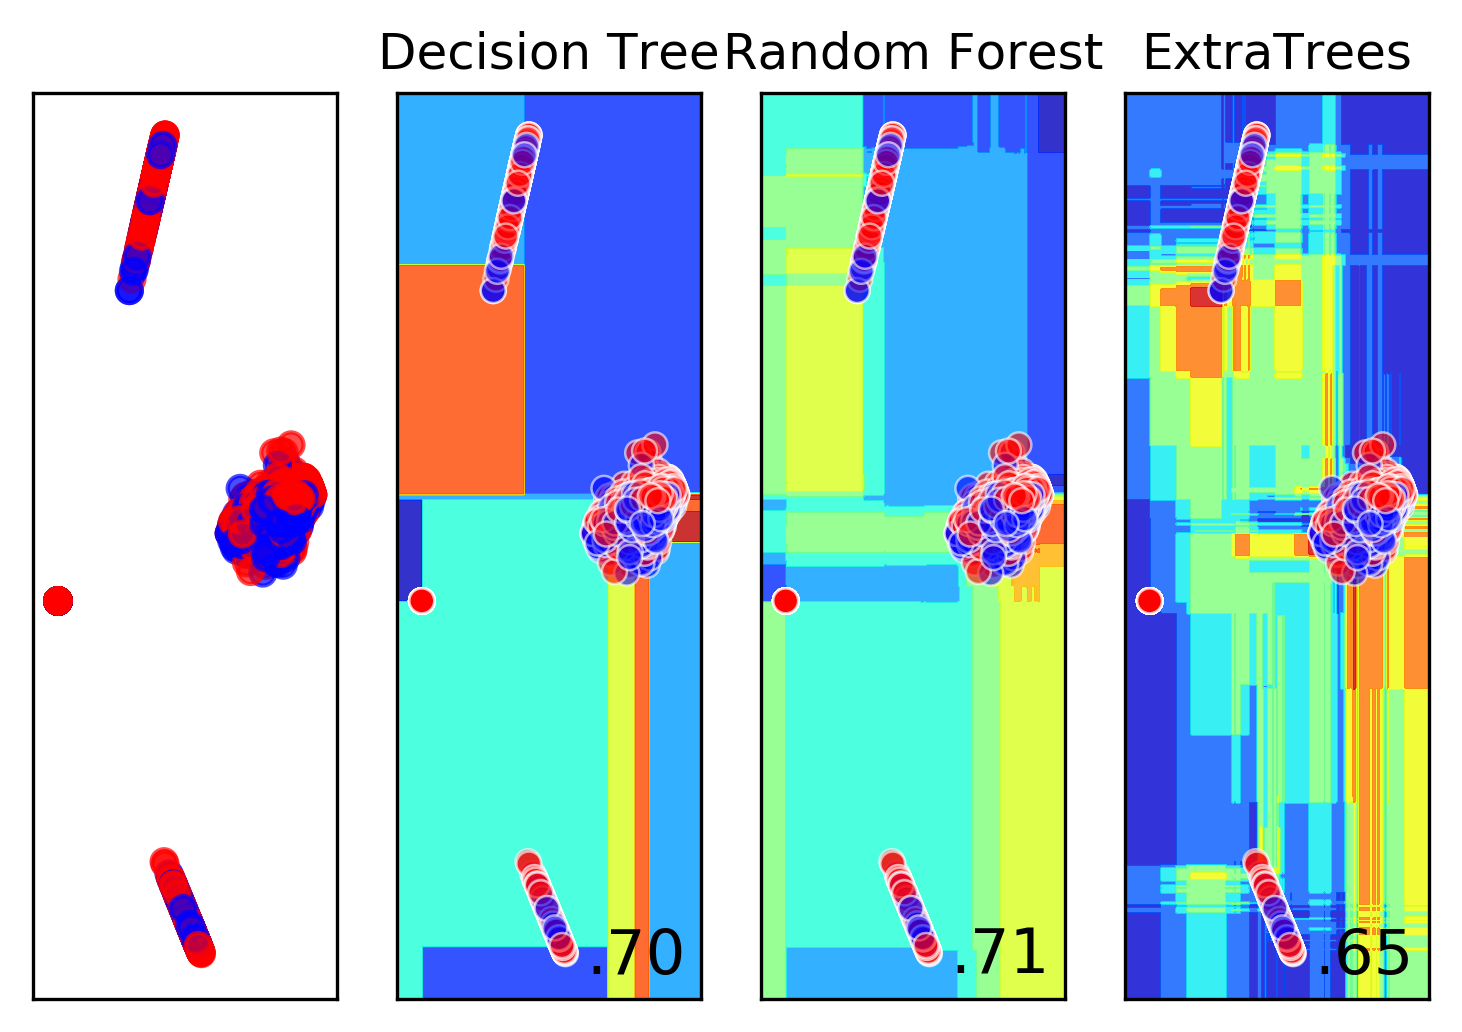

In [241]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.tree as sktree
import sklearn.ensemble as sken

treeclassifiers = [
    sktree.DecisionTreeClassifier(max_depth=5),
    sken.RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1),
    sken.ExtraTreesClassifier()]
names = ["Decision Tree", "Random Forest", "ExtraTrees"]
figure = plt.figure(figsize=(12, 10))
h = 0.02
i = 1

# preprocess dataset, split into training and test part
X, y = ds[['f1', 'f2']], ds['label']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.jet
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.figure(dpi=300)
ax = plt.subplot(1, len(treeclassifiers) + 1, i)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.7)
# and testing points
#ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, treeclassifiers):
    ax = plt.subplot(1, len(treeclassifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.jet, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.6, linewidths=0.6, edgecolors="white")
    # and testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               #alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

# 无监督

去掉标签：label

In [267]:
df = df.drop('label')
print(df.columns)

['BIRTH_PLACE', 'MOTHER_AGE_YEARS', 'FATHER_COMBINED_AGE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'DIABETES_PRE', 'DIABETES_GEST', 'HYP_TENS_PRE', 'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM', 'BIRTH_PLACE_INT']


## PIC（幂迭代聚类）
- 将数据抽象成点、边、距离的数据结构，具体来说每条数据为(src, dst, weight)的格式，src和dst分别是两个点，weight是两个点之间的距离  

In [264]:
df.count(), len(df.columns)

(45429, 18)

In [270]:
print(df.columns)

['BIRTH_PLACE', 'MOTHER_AGE_YEARS', 'FATHER_COMBINED_AGE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'DIABETES_PRE', 'DIABETES_GEST', 'HYP_TENS_PRE', 'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM', 'BIRTH_PLACE_INT']


### 数据改造
- 构造相似函数： 之前有监督的算法找到了最显著的特征是MOTHER_WEIGHT_GAIN，那我们就利用这个特征构建相似性。两个点之间的相似度为MOTHER_WEIGHT_GAIN的差的绝对值

采样一小部分数据出来作实验

In [302]:
df = df.sample(False, 100/df.count(), 42)
print('采样出%d个样本' % df.count())

# 加一个id列, src是id列
df = df.withColumn("src", F.monotonically_increasing_id())

Pipeline: 特征集中->数据归一化

In [356]:
#cols = label['FATHER_COMBINED_AGE', 'MOTHER_WEIGHT_GAIN']
cols = [col[0] for col in labels[2:]]
featuresCreator = ft.VectorAssembler(
    inputCols=cols,
    outputCol='features'
)

minmax = ft.MinMaxScaler(inputCol='features', outputCol='scaled_features')

pipeline = Pipeline(stages=[encoder, featuresCreator, minmax])

tr = pipeline.fit(df).transform(df).select('src', 'scaled_features')
tr.show(4)

+---+--------------------+
|src|     scaled_features|
+---+--------------------+
|  0|[0.24137931034482...|
|  1|[0.48275862068965...|
|  2|[0.41379310344827...|
|  3|[0.17241379310344...|
+---+--------------------+
only showing top 4 rows



通过自关联实现(src, dst)节点数据

In [357]:
# copy一列出来作自关联，id列改名为dst，其他所有变量都加dst前缀
tr1 = tr.select('*')
for f in tr1.columns:
    tr1 = tr1.withColumnRenamed(f, 'dst_%s' % f)
tr1 = tr1.select('*').withColumnRenamed('dst_src', 'dst')
print(tr1.columns)

df_join = tr.join(tr1, tr['src'] != tr1['dst'], 'left')
print(df_join.count())

print('total %d个样本能关联上' % (df_join.select('src').distinct().count()))

df_join.show(4)

['dst', 'dst_scaled_features']


计算两个节点之间的相似程度作为weight，并最终将数据变成(src, dst, weight）的形式

In [362]:
distance_udf = F.udf(lambda x, y: float(distance.euclidean(x, y)), T.FloatType())
df_join = df_join.withColumn('weight', distance_udf(F.col('scaled_features'), F.col('dst_scaled_features')))
df_join.select('src', 'dst', 'weight').show(5)

+---+---+----------+
|src|dst|    weight|
+---+---+----------+
|  0|  1|0.36280426|
|  0|  2|0.39745304|
|  0|  3| 0.9410883|
|  0|  4| 1.6573156|
|  0|  5| 0.5368422|
+---+---+----------+
only showing top 5 rows



### 聚类算法

In [480]:
?PowerIterationClustering

In [363]:
# k是聚类数目
pic = PowerIterationClustering(k=2, weightCol="weight")
pic.setMaxIter(40)
assignments = pic.assignClusters(df_join.select('src', 'dst', 'weight'))
assignments.sort(assignments.id).show(5)

+---+-------+
| id|cluster|
+---+-------+
|  0|      0|
|  1|      0|
|  2|      0|
|  3|      0|
|  4|      0|
+---+-------+
only showing top 5 rows



In [364]:
print('total %d个样本在聚类中' % (assignments.select('id').distinct().count()))

total 95个样本在聚类中


In [365]:
assignments.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|    3|
|      0|   92|
+-------+-----+



### 可视化展示聚类结果 

- 降维到2D空间  
- 与聚类结果关联  

In [367]:
pcaCreator = ft.PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
data_2d = pcaCreator.fit(tr).transform(tr).select('pca_features', 'src').withColumnRenamed('src', 'id')
data_2d.show(4)
data_2d_with_cluster = assignments.join(data_2d, 'id', 'left')
data_2d_with_cluster.show(4)

+--------------------+---+
|        pca_features| id|
+--------------------+---+
|[-0.0396034149526...|  0|
|[-0.2588902222313...|  1|
|[-0.3076063870579...|  2|
|[-0.4386074171007...|  3|
+--------------------+---+
only showing top 4 rows

+---+-------+--------------------+
| id|cluster|        pca_features|
+---+-------+--------------------+
| 39|      0|[-0.3822340132233...|
| 34|      0|[-0.1869461746901...|
|101|      0|[-0.1943548653992...|
|  4|      0|[-1.3425670495062...|
+---+-------+--------------------+
only showing top 4 rows



转到pandas里画图

In [368]:
ds = data_2d_with_cluster.toPandas()
ds['f1'] = ds.apply(lambda x: x['pca_features'][0], axis=1)
ds['f2'] = ds.apply(lambda x: x['pca_features'][1], axis=1)
ds = ds.drop('pca_features', axis=1)
ds.head()

,id,cluster,f1,f2
0,39,0,-0.382234,-0.814056
1,34,0,-0.186946,-0.153256
2,101,0,-0.194355,-0.128657
3,4,0,-1.342567,-0.826838
4,71,0,-0.284284,-0.093605


作图

Text(0.5,1,'PCI clustering')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


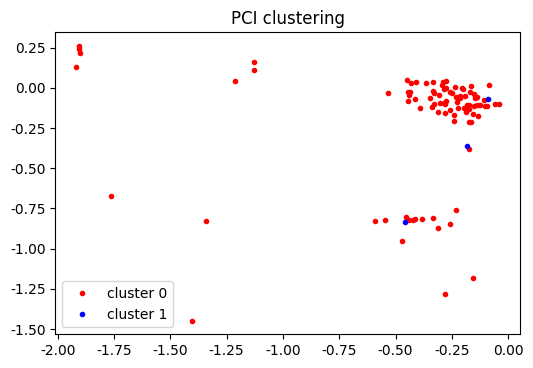

In [371]:
colors = ['r.', 'b.']
ds0 = ds.query('cluster == 0')
ds1 = ds.query('cluster == 1')

plt.figure(dpi=100)
plt.plot(ds0['f1'], ds0['f2'], 'r.', label='cluster 0')
plt.plot(ds1['f1'], ds1['f2'], 'b.', label='cluster 1')
plt.legend()
plt.title('PCI clustering')

## BisectingKMeans

### 读入csv数据

In [700]:
df = spark.read.csv('df_transformed.csv.gz', 
                        inferSchema = True,
                        header=True)

In [701]:
df.printSchema()

root
 |-- INFANT_ALIVE_AT_REPORT: integer (nullable = true)
 |-- BIRTH_PLACE: integer (nullable = true)
 |-- MOTHER_AGE_YEARS: integer (nullable = true)
 |-- FATHER_COMBINED_AGE: integer (nullable = true)
 |-- CIG_BEFORE: integer (nullable = true)
 |-- CIG_1_TRI: integer (nullable = true)
 |-- CIG_2_TRI: integer (nullable = true)
 |-- CIG_3_TRI: integer (nullable = true)
 |-- MOTHER_HEIGHT_IN: integer (nullable = true)
 |-- MOTHER_PRE_WEIGHT: integer (nullable = true)
 |-- MOTHER_DELIVERY_WEIGHT: integer (nullable = true)
 |-- MOTHER_WEIGHT_GAIN: integer (nullable = true)
 |-- DIABETES_PRE: integer (nullable = true)
 |-- DIABETES_GEST: integer (nullable = true)
 |-- HYP_TENS_PRE: integer (nullable = true)
 |-- HYP_TENS_GEST: integer (nullable = true)
 |-- PREV_BIRTH_PRETERM: integer (nullable = true)



### 聚类

将所有feature合并到一起作为一个变量

In [702]:
cols = ['MOTHER_AGE_YEARS', 'FATHER_COMBINED_AGE', 'CIG_BEFORE', 'CIG_1_TRI', 'CIG_2_TRI', 'CIG_3_TRI', 'MOTHER_HEIGHT_IN', 'MOTHER_PRE_WEIGHT', 'MOTHER_DELIVERY_WEIGHT', 'MOTHER_WEIGHT_GAIN', 'DIABETES_PRE', 'DIABETES_GEST', 'HYP_TENS_PRE', 'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM']
featuresCreator = ft.VectorAssembler(
    inputCols=cols,
    outputCol='features'
)
df = featuresCreator.transform(df).select('features')
df.show(4)

+--------------------+
|            features|
+--------------------+
|(15,[0,1,6,7,8,9]...|
|(15,[0,1,6,7,8,9]...|
|(15,[0,1,6,7,8,9]...|
|(15,[0,1,6,7,8,9,...|
+--------------------+
only showing top 4 rows



In [703]:
# 聚类算法
K = 4
bkm = BisectingKMeans(k=K, minDivisibleClusterSize=1.0)
model = bkm.fit(df)

# 聚类结果
transformed = model.transform(df).select("features", "prediction")

# 聚类中心点
centers = model.clusterCenters()
centers

[array([2.80769595e+01, 4.26961165e+01, 1.37550275e+00, 8.77074391e-01,
        6.77324501e-01, 5.59671477e-01, 6.39087437e+01, 1.37939737e+02,
        1.62398452e+02, 2.49796870e+01, 6.75972556e-03, 3.58265454e-02,
        1.20661101e-02, 3.59279413e-02, 4.93121979e-02]),
 array([2.87589913e+01, 4.55030178e+01, 1.65878462e+00, 1.00661430e+00,
        7.70483671e-01, 6.25713105e-01, 6.54193468e+01, 2.15467053e+02,
        2.37383464e+02, 2.36840843e+01, 2.48036379e-02, 6.89541133e-02,
        5.18396031e-02, 7.82141381e-02, 5.72964035e-02]),
 array([2.87305743e+01, 5.46330236e+01, 1.29138514e+00, 8.78800676e-01,
        7.27618243e-01, 6.16554054e-01, 6.70777027e+01, 7.09524916e+02,
        4.66829814e+02, 9.90000000e+01, 1.39358108e-02, 2.74493243e-02,
        2.87162162e-02, 3.67398649e-02, 5.91216216e-02]),
 array([2.82683104e+01, 5.86446701e+01, 7.64321972e-01, 6.82378535e-01,
        6.02610587e-01, 5.53299492e-01, 8.51501088e+01, 9.98546773e+02,
        9.99000000e+02, 9.90000000

In [704]:
transformed.show(4)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|(15,[0,1,6,7,8,9]...|         3|
|(15,[0,1,6,7,8,9]...|         1|
|(15,[0,1,6,7,8,9]...|         0|
|(15,[0,1,6,7,8,9,...|         0|
+--------------------+----------+
only showing top 4 rows



In [705]:
transformed.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|12095|
|         3| 1379|
|         2| 2368|
|         0|29587|
+----------+-----+



将聚类中心的坐标合并到一起

In [706]:
center_df = spark.createDataFrame(pd.DataFrame(centers))
featuresCreator = ft.VectorAssembler(
    inputCols=['%s' % i for i in range(centers[0].shape[0])],
    outputCol='features'
)
center_df = featuresCreator.transform(center_df).select('features')
center_df = center_df.withColumn('prediction', F.lit(-1))
center_df.show(4)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[28.0769594754452...|        -1|
|[28.7589913187267...|        -1|
|[28.7305743243243...|        -1|
|[28.2683103698332...|        -1|
+--------------------+----------+



In [531]:
print('与聚类中合并前有%d行' % df.count())
df1 = transformed.union(center_df)
print('与聚类中合并后有%d行' % df1.count())

与聚类中合并前有45429行
与聚类中合并后有45433行


将数据与聚类中心一起降维到2D空间

In [532]:
pcaCreator = ft.PCA(k=2, inputCol='features', outputCol='pca_features')
data_2d = pcaCreator.fit(df1).transform(df1)
data_2d.show(4)

+--------------------+----------+--------------------+
|            features|prediction|        pca_features|
+--------------------+----------+--------------------+
|(15,[0,1,6,7,8,9]...|         3|[-1404.8034275117...|
|(15,[0,1,6,7,8,9]...|         1|[-264.73645838678...|
|(15,[0,1,6,7,8,9]...|         0|[-225.93822198696...|
|(15,[0,1,6,7,8,9,...|         0|[-196.35029680272...|
+--------------------+----------+--------------------+
only showing top 4 rows



In [533]:
ds = data_2d.toPandas()
ds['f1'] = ds.apply(lambda x: x['pca_features'][0], axis=1)
ds['f2'] = ds.apply(lambda x: x['pca_features'][1], axis=1)
ds = ds.drop('pca_features', axis=1)
ds.head()

,features,prediction,f1,f2
0,"(29.0, 99.0, 0.0, 0.0, 0.0, 0.0, 99.0, 999.0, ...",3,-1404.803428,-198.685858
1,"(22.0, 29.0, 0.0, 0.0, 0.0, 0.0, 65.0, 180.0, ...",1,-264.736458,-50.341330
2,"(38.0, 40.0, 0.0, 0.0, 0.0, 0.0, 63.0, 155.0, ...",0,-225.938222,-40.504507
3,"(39.0, 42.0, 0.0, 0.0, 0.0, 0.0, 60.0, 128.0, ...",0,-196.350297,-44.795192
4,"[18.0, 99.0, 6.0, 4.0, 2.0, 2.0, 61.0, 110.0, ...",0,-169.371659,-37.817236


### 可视化

Text(0.5,1,'Kmeans clustering')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


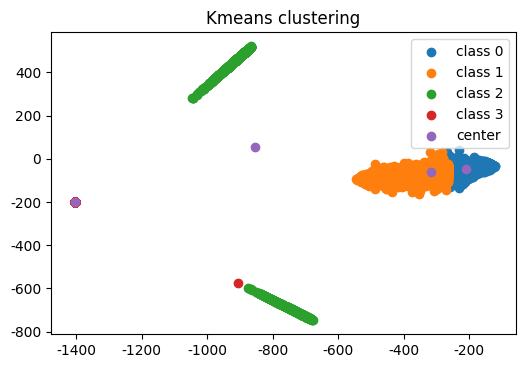

In [537]:
plt.figure(dpi=105)
color = ['.b', '.k', '.g', '.']
for k in range(K):
    ds_k = ds.query('prediction==%d' % k)
    plt.scatter(ds_k['f1'], ds_k['f2'], label='class %d' % k)


ds_center = ds[-K:]    
plt.scatter(ds_center['f1'], ds_center['f2'], label='center')
plt.legend()
plt.title('Kmeans clustering')


## FP-Growth

### demo1

In [602]:
data = spark.read.csv('/notebook/sparkcoding/Spark-/movie_recommender/data/MovieLens/movies.csv', 
                        header=True)
data.show(4)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
+-------+--------------------+--------------------+
only showing top 4 rows



In [652]:
split_word = F.udf(lambda x: ', '.join(x.split('|')))
data = data.withColumn('items', F.array(split_word(F.col('genres'))))
data.select('items').show(4)
data.printSchema()

+--------------------+
|               items|
+--------------------+
|[Adventure, Anima...|
|[Adventure, Child...|
|   [Comedy, Romance]|
|[Comedy, Drama, R...|
+--------------------+
only showing top 4 rows

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- items: array (nullable = false)
 |    |-- element: string (containsNull = true)



- 支持度support(A => B) = P(AnB) = |A n B| / |N|，表示数据集D中，事件A和事件B共同出现的概率；   
- 置信度confidence(A => B) = P(B|A) = |A n B| / |A|，表示数据集D中，出现事件A的事件中出现事件B的概率；  
- 提升度lift(A => B) = P(B|A):P(B) = |A n B| / |A| : |B| / |N|，表示数据集D中，出现A的条件下出现事件B的概率和没有条件A出现B的概率；

In [653]:
fp = FPGrowth(minSupport=0.01, minConfidence=0.1)
fpm = fp.fit(data)
fpm.freqItemsets.sort('freq', ascending=False).show(5)


+-----------------+----+
|            items|freq|
+-----------------+----+
|          [Drama]|1053|
|         [Comedy]| 946|
|  [Comedy, Drama]| 435|
|[Comedy, Romance]| 363|
| [Drama, Romance]| 349|
+-----------------+----+
only showing top 5 rows



通过置信度筛选出推荐规则则
- antecedent表示前项
- consequent表示后项
- confidence表示规则的置信度

In [650]:
fpm.associationRules.show(4)

+----------+----------+----------+----+
|antecedent|consequent|confidence|lift|
+----------+----------+----------+----+
+----------+----------+----------+----+



### demo2

In [580]:
data_list=[[['r', 'z', 'h', 'k', 'p']]\
           ,[['z', 'y', 'x', 'w', 'v', 'u', 't', 's']]\
           ,[['s', 'x', 'o', 'n', 'r']]\
           ,[['x', 'z', 'y', 'm', 't', 's', 'q', 'e']]\
           ,[['z']]\
           ,[['x', 'z', 'y', 'r', 'q', 't', 'p']]]#数据集
demo=spark.createDataFrame(data_list,["items"])
demo.printSchema()
demo.show(4)


root
 |-- items: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+
|               items|
+--------------------+
|     [r, z, h, k, p]|
|[z, y, x, w, v, u...|
|     [s, x, o, n, r]|
|[x, z, y, m, t, s...|
+--------------------+
only showing top 4 rows



In [637]:
fp = FPGrowth(minSupport=0.3, minConfidence=0.7)
fpm = fp.fit(demo)
fpm.freqItemsets.show(5)
fpm.associationRules.show(5)

+---------+----+
|    items|freq|
+---------+----+
|      [s]|   3|
|   [s, x]|   3|
|[s, x, z]|   2|
|   [s, z]|   2|
|      [r]|   3|
+---------+----+
only showing top 5 rows

+----------+----------+----------+----+
|antecedent|consequent|confidence|lift|
+----------+----------+----------+----+
|    [t, s]|       [y]|       1.0| 2.0|
|    [t, s]|       [x]|       1.0| 1.5|
|    [t, s]|       [z]|       1.0| 1.2|
|       [p]|       [r]|       1.0| 2.0|
|       [p]|       [z]|       1.0| 1.2|
+----------+----------+----------+----+
only showing top 5 rows

